<a href="https://colab.research.google.com/github/BradleyConlin/EDA_Tutorials/blob/main/Introduction_EDA_Cybersec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>What is Colaboratory?

Colaboratory, or "Colab" for short, allows you to write and execute Python in your browser, with 
- Zero configuration required
- Free access to GPUs
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more, or just get started below!

# Introduction

<h1>Exploratory Data Analysis (EDA) Walkthrough</h1>

The goal of this walkthrough is to help show you the process done by analysts and researchers. EDA is one of the most important first steps when dealing with new data. 

<i>EDA allows us to better understand the data and the tools we can use in future steps.</i>

<h1> Business Context</h1>

You are a new cybersecurity analyst, and have been tasked with finding out some more information on recent events that have happened over our network.

1) Most targeted Destination IP Address<br>
2) Most Ports attacked<br>
3) Most Frequently/common type of Attack<br>
4) Different time of the day , (odd , hours, day or night)<br>
5) Find the Pattern

## Setup

The following lines of code are installing certain libraries or dependencies for the notebook to run properly.

In [152]:
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import ipaddress
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from datetime import datetime, timedelta
import math
import missingno as msno
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

In [153]:
df1 = pd.read_csv('https://media.githubusercontent.com/media/BradleyConlin/EDA_Tutorials/main/Network_Traffic_Events_1.csv')

df1.shape

(49998, 11)

In [154]:
df2 = pd.read_csv('https://media.githubusercontent.com/media/BradleyConlin/EDA_Tutorials/main/Network_Traffic_Events_2.csv')

df2.shape

(46615, 11)

In [155]:
combined = [df1, df2]
df = pd.concat(combined)
df.shape

(96613, 11)

# EDA First Steps

## Initial Discovery

The following 3 cells of code will show us the type of data we are working with.

In [156]:
df.shape

(96613, 11)

In [157]:
df.columns

Index(['Attack category', 'Attack subcategory', 'Protocol', 'Source IP',
       'Source Port', 'Destination IP', 'Destination Port', 'Attack Name',
       'Attack Reference', '.', 'Time'],
      dtype='object')

In [158]:
df.head(4)

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time
0,Backdoors,,unas,187.48.276.0,4300,149.171.126.12,3106,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,.,1421930753-1421930753
1,Backdoors,,ospf,175.45.171.2,4780,149.171.126.11,9338,Vtiger CRM Unauthenticated Password Reset (htt...,CVE 2014-2269 (http://cve.mitre.org/cgi-bin/cv...,.,1421933441-1421933499
2,Backdoors,,sctp,175.45.171.3,8270,149.171.126.12,18703,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,.,1421930723-1421930723
3,Exploits,Apache,ospf,175.45.171.3,9172,149.171.126.19,10987,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,.,1424255680-1424255681


## Initial Cleaning

We can see in the above cell that the time is given to us in a range, we will need to change this to make it more user friendly

Furthermore, there appears to be a missing value under <i>Attack Reference</i> and a column titled ".". 

These will need to be dealt with.

___

<i>***Example of Feature Engineering***</i>

In [159]:
df[['Start time','Last time']] = df['Time'].str.split('-',expand=True)
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time,Start time,Last time
0,Backdoors,,unas,187.48.276.0,4300,149.171.126.12,3106,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,.,1421930753-1421930753,1421930753,1421930753
1,Backdoors,,ospf,175.45.171.2,4780,149.171.126.11,9338,Vtiger CRM Unauthenticated Password Reset (htt...,CVE 2014-2269 (http://cve.mitre.org/cgi-bin/cv...,.,1421933441-1421933499,1421933441,1421933499
2,Backdoors,,sctp,175.45.171.3,8270,149.171.126.12,18703,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,.,1421930723-1421930723,1421930723,1421930723
3,Exploits,Apache,ospf,175.45.171.3,9172,149.171.126.19,10987,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,.,1424255680-1424255681,1424255680,1424255681
4,Exploits,Apache,unas,175.45.176.2,21663,149.171.126.17,8923,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,.,1424258880-1424258880,1424258880,1424258880


Next we will check to see if the "." holds any data worth saving. 

In [160]:
df.dtypes

Attack category       object
Attack subcategory    object
Protocol              object
Source IP             object
Source Port            int64
Destination IP        object
Destination Port       int64
Attack Name           object
Attack Reference      object
.                     object
Time                  object
Start time            object
Last time             object
dtype: object

In [161]:
df['.'].unique()

array(['.'], dtype=object)

Given that the "." column is empty, we will next delete this column and the old <i>Time</i> column to clean up our data

In [162]:
df = df.drop(['.', 'Time'],axis=1)
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
0,Backdoors,,unas,187.48.276.0,4300,149.171.126.12,3106,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,1421930753,1421930753
1,Backdoors,,ospf,175.45.171.2,4780,149.171.126.11,9338,Vtiger CRM Unauthenticated Password Reset (htt...,CVE 2014-2269 (http://cve.mitre.org/cgi-bin/cv...,1421933441,1421933499
2,Backdoors,,sctp,175.45.171.3,8270,149.171.126.12,18703,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,1421930723,1421930723
3,Exploits,Apache,ospf,175.45.171.3,9172,149.171.126.19,10987,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,1424255680,1424255681
4,Exploits,Apache,unas,175.45.176.2,21663,149.171.126.17,8923,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,1424258880,1424258880


<h2>Check our shape, make sure we didn't make any mistakes</h2>

In [163]:
df.shape

(96613, 11)

## Graphical Analysis

The following code will show us in a visual manner how the data is distributed when it comes to missing data. 

Given our lack of knowledge on the data, and the size of the data, it is best for us to ignore these entries.

***Left***: Matrix shows the distribution of missing data

***Right***: Bar chart showing the total number of values <i>(anything less than 178031 means missing data)</i>

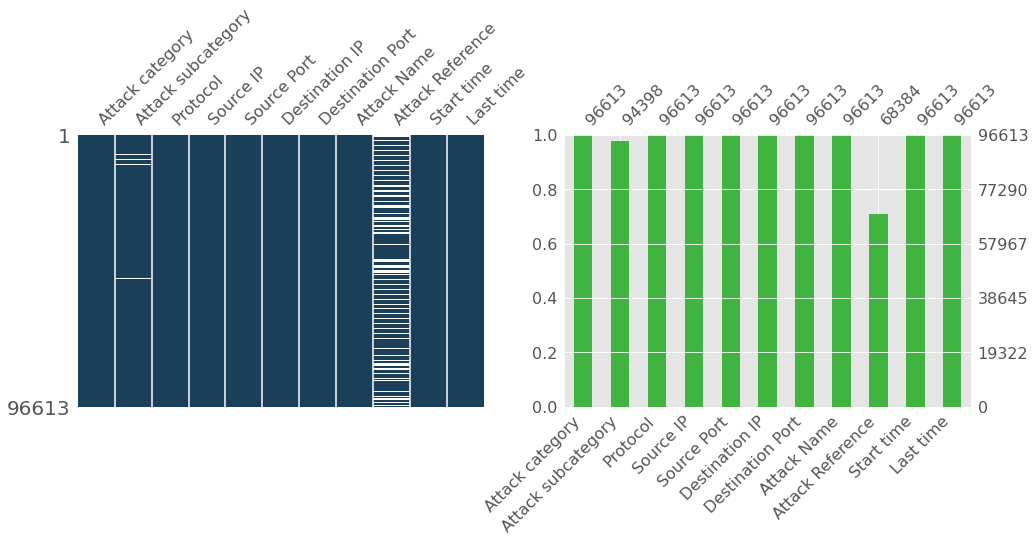

In [164]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
msno.matrix(df, ax=ax1, sparkline=False, color=(0.1, 0.25, 0.35))
msno.bar(df, ax=ax2, color=(0.25, 0.7, 0.25))
plt.show()

## Secondary Cleaning

To see more clearly how many data points are missing, the following code will help us see these values in a more aggregated view

In [165]:
df.isnull().sum()

Attack category           0
Attack subcategory     2215
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               0
Attack Reference      28229
Start time                0
Last time                 0
dtype: int64

In [166]:
# Moving unknown Attack subcategory to "Not Registered" or you could use "other"

df["Attack subcategory"] = df["Attack subcategory"].fillna("Not Registered")

In [167]:
df.isnull().sum()

Attack category           0
Attack subcategory        0
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               0
Attack Reference      28229
Start time                0
Last time                 0
dtype: int64

In [168]:
df[pd.isnull(df).any(axis=1)].shape

(28229, 11)

After checking to see if we have properly removed the <i>Attack subcatoegory</i> and checking the shape again, we will see if we have any duplicate line items.

In [169]:
df[df.duplicated()].shape

(12, 11)

Since we have 12 duplicates, we will remove the duplicates, and check our results once again.



In [170]:
print('Dimensions after dropping duplicated rows: ' + str(df.shape))

Dimensions after dropping duplicated rows: (96613, 11)


In [171]:
# This chart should be empty, it is showing us the duplicates that remain

df[df.duplicated()]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
46603,Exploits,Miscellaneous,ddx,175.45.176.3,79900,149.171.126.19,0,Rhino Serv-U File Server Buffer Overflow (http...,CVE 2009-4006 (http://cve.mitre.org/cgi-bin/cv...,1424230297,1424230297
46604,Generic,IXIA,udp,175.45.176.0,79909,149.171.126.10,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2009-0234 (http://cve.mitre.org/cgi-bin/cv...,1424259166,1424259166
46605,Fuzzers,OSPF,unas,175.45.176.1,79953,149.171.126.17,0,Fuzzer: OSPF Database Description Packet: Back...,NaN,1424244446,1424244446
46606,Fuzzers,Syslog,udp,187.48.276.1,79983,149.171.126.13,514,Fuzzer: Syslog Invalid Tag (Numeric) (https://...,NaN,1424226568,1424226568
46607,Reconnaissance,SunRPC Portmapper (UDP) UDP Service,udp,187.48.276.1,79991,149.171.126.18,111,SunRPC UDP Portmapper GETPORT Request (statmon...,NaN,1424221979,1424221979
46608,Exploits,Clientside,tcp,175.45.176.0,79999,149.171.126.13,80,Microsoft Data Access Components Insecure Libr...,CVE 2011-1975 (http://cve.mitre.org/cgi-bin/cv...,1424246052,1424246054
46609,Exploits,Miscellaneous,ddx,175.45.176.3,79900,149.171.126.19,0,Rhino Serv-U File Server Buffer Overflow (http...,CVE 2009-4006 (http://cve.mitre.org/cgi-bin/cv...,1424230297,1424230297
46610,Generic,IXIA,udp,175.45.176.0,79909,149.171.126.10,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2009-0234 (http://cve.mitre.org/cgi-bin/cv...,1424259166,1424259166
46611,Fuzzers,OSPF,unas,175.45.176.1,79953,149.171.126.17,0,Fuzzer: OSPF Database Description Packet: Back...,NaN,1424244446,1424244446
46612,Fuzzers,Syslog,udp,187.48.276.1,79983,149.171.126.13,514,Fuzzer: Syslog Invalid Tag (Numeric) (https://...,NaN,1424226568,1424226568


The only valid port ranges are between ***0*** and ***65535***.

As we saw from our original investigation, there are values beyond these limits, which means we need to clean up the data
___

<i>***Garbage In, Garbage Out***</i>

The following code will take any entries with invalid port values, and store them into their own dataframe (df)

In [172]:
invalid_SP = (df['Source Port'] < 0) | (df['Source Port'] > 65535)
invalid_DP = (df['Destination Port'] < 0) | (df['Destination Port'] > 65535)
df[invalid_SP | invalid_DP]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
32,Exploits,Apache,ifmp,175.45.186.6,4835,149.171.126.19,-162,Apache Camel XML CamelXsltResourceUri Java Cod...,CVE 2014-0003 (http://cve.mitre.org/cgi-bin/cv...,1424230283,1424230283
113,Exploits,ICMP,il,175.45.171.2,811,149.171.126.10,-63,Linux Kernel ICMP_Send Remote Denial Of Servic...,CVE 2006-0454 (http://cve.mitre.org/cgi-bin/cv...,1424237293,1424237293
223,Reconnaissance,ICMP,nsfnet-igp,175.45.195.1,19883,149.171.126.17,-166,IP Options: Loose Source Route (IP Option 3) (...,NaN,1424244390,1424244390
277,Reconnaissance,ICMP,unas,175.45.171.2,18460,149.171.126.17,-167,IP Options: Extended Security (IP Option 5) (h...,NaN,1424258898,1424258898
340,Fuzzers,OSPF,unas,175.45.176.0,11753,149.171.126.17,-208,Fuzzer: OSPF Hello Packet: Invalid Length (htt...,NaN,1424251717,1424251717
...,...,...,...,...,...,...,...,...,...,...,...
46610,Generic,IXIA,udp,175.45.176.0,79909,149.171.126.10,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2009-0234 (http://cve.mitre.org/cgi-bin/cv...,1424259166,1424259166
46611,Fuzzers,OSPF,unas,175.45.176.1,79953,149.171.126.17,0,Fuzzer: OSPF Database Description Packet: Back...,NaN,1424244446,1424244446
46612,Fuzzers,Syslog,udp,187.48.276.1,79983,149.171.126.13,514,Fuzzer: Syslog Invalid Tag (Numeric) (https://...,NaN,1424226568,1424226568
46613,Reconnaissance,SunRPC Portmapper (UDP) UDP Service,udp,187.48.276.1,79991,149.171.126.18,111,SunRPC UDP Portmapper GETPORT Request (statmon...,NaN,1424221979,1424221979


We will now delete the invalid entries and check the shape...again.

In [173]:
df = df[~(invalid_SP | invalid_DP)].reset_index(drop=True)


In [174]:
df.shape

(94444, 11)

We will now check some of the data inside the df to make sure it is clean and accurate.

In [175]:
print('Total number of different protocols:', len(df['Protocol'].unique()))
print('Total number of different Attack categories:', len(df['Attack category'].unique()))
df['Protocol'].unique()

Total number of different protocols: 131
Total number of different Attack categories: 12


array(['unas', 'ospf', 'sctp', 'ttp', 'any', 'kryptolan', 'wsn', 'ib',
       'br-sat-mon', 'encap', 'dgp', 'leaf-2', 'il', 'sps', 'sccopmce',
       'skip', 'gre', 'vines', 'ipnip', 'l2tp', 'iso-tp4', 'bbn-rcc',
       'rsvp', 'ax.25', 'tlsp', 'ipv6-no', 'ifmp', 'compaq-peer', 'prm',
       'iplt', 'visa', 'netblt', 'ippc', 'etherip', 'trunk-1', 'mobile',
       'emcon', 'pipe', 'fire', 'nsfnet-igp', 'merit-inp', 'larp', 'ipip',
       'chaos', 'pim', 'fc', 'ip', 'ipv6', 'pri-enc', 'xns-idp',
       'trunk-2', 'wb-expak', 'cbt', 'idpr-cmtp', 'ipv6-route', 'mux',
       'tp++', 'snp', 'ipv6-frag', 'mtp', 'mfe-nsp', 'ptp', 'qnx', 'iatp',
       'ipx-n-ip', 'idrp', 'ddp', 'iso-ip', 'rdp', 'ddx', 'sun-nd', 'bna',
       'sm', 'wb-mon', 'pup', 'isis', 'rvd', 'pvp', 'st2', 'ipcv', 'vmtp',
       'cpnx', 'a/n', 'swipe', 'stp', 'scps', 'nvp', 'cftp', 'pnni',
       'gmtp', 'irtp', 'uti', 'hmp', 'ggp', 'smp', 'eigrp', 'ipcomp',
       'aris', 'ipv6-opts', 'sep', 'egp', 'sat-expak', 'secure-vmt

As we can see, there are multiple duplications in the list.

<i>TCP, UDP, etc.</i>

The following code will show us the same for the attack categories.

In [176]:
df['Attack category'].unique()

array(['Backdoors', 'Exploits', 'DoS', 'Reconnaissance ', 'Fuzzers',
       'Generic', 'Analysis', ' Analysis', 'Backdoor', 'Analysis ',
       'Shellcode ', 'Worms'], dtype=object)

As we can see, there are duplicates due to poor spelling. We will remove white space, uppercase the letters and align "<i>BACKDOOR</i>" and "<i>BACKDOORS</i>".

In [177]:
df['Protocol'] = df['Protocol'].str.upper().str.strip()
df['Attack category'] = df['Attack category'].str.upper().str.strip()
df['Attack category'] = df['Attack category'].str.strip().replace('BACKDOORS','BACKDOOR')

df

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
0,BACKDOOR,,UNAS,187.48.276.0,4300,149.171.126.12,3106,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,1421930753,1421930753
1,BACKDOOR,,OSPF,175.45.171.2,4780,149.171.126.11,9338,Vtiger CRM Unauthenticated Password Reset (htt...,CVE 2014-2269 (http://cve.mitre.org/cgi-bin/cv...,1421933441,1421933499
2,BACKDOOR,,SCTP,175.45.171.3,8270,149.171.126.12,18703,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,1421930723,1421930723
3,EXPLOITS,Apache,OSPF,175.45.171.3,9172,149.171.126.19,10987,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,1424255680,1424255681
4,EXPLOITS,Apache,UNAS,175.45.176.2,21663,149.171.126.17,8923,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,1424258880,1424258880
...,...,...,...,...,...,...,...,...,...,...,...
94439,FUZZERS,Syslog,UDP,175.45.195.1,65535,149.171.126.14,514,Fuzzer: Syslog Invalid Timestamp (Numeric) (ht...,NaN,1424224898,1424224915
94440,GENERIC,IXIA,TCP,175.45.176.3,65535,149.171.126.11,80,Ipswitch_WhatsUp_Web_Interface_SQL_Injection_a...,CVE 2005-1250 (http://cve.mitre.org/cgi-bin/cv...,1424240116,1424240118
94441,FUZZERS,RIP,UDP,175.45.176.0,65535,149.171.126.13,520,Fuzzer: RIP Entry Address Family Field (https:...,NaN,1424224609,1424224609
94442,FUZZERS,Syslog,UDP,175.45.176.2,65535,149.171.126.14,514,Fuzzer: Syslog Invalid Timestamp (Numeric) (ht...,NaN,1424224898,1424224915


Check to make sure the operation executed properly. 

In [178]:
print('Total number of different protocols:', len(df['Protocol'].unique()))
print('Total number of different Attack categories:', len(df['Attack category'].unique()))

Total number of different protocols: 129
Total number of different Attack categories: 9


Now to look at <i>Attack Reference</i> for missing values.

In [179]:
df[pd.isnull(df['Attack Reference'])]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
131,RECONNAISSANCE,ICMP,SNP,175.45.186.5,2885,149.171.126.17,19363,ICMP Address Mask Request Message (https://str...,NaN,1424244398,1424244398
132,RECONNAISSANCE,ICMP,IPV6-FRAG,175.45.171.3,9092,149.171.126.17,14617,IP Options: Record Route (IP Option 7) (https:...,NaN,1424244376,1424244376
133,RECONNAISSANCE,ICMP,MTP,175.45.176.3,10332,149.171.126.19,23977,ICMP Echo Reply (https://strikecenter.bpointsy...,NaN,1424230276,1424230276
134,RECONNAISSANCE,ICMP,UNAS,175.45.176.3,6917,149.171.126.19,6957,IP Options: Extended Security (IP Option 5) (h...,NaN,1424230359,1424230359
135,RECONNAISSANCE,ICMP,EMCON,175.45.195.1,6968,149.171.126.19,8652,IP Options: Record Route (IP Option 7) (https:...,NaN,1424230194,1424230194
...,...,...,...,...,...,...,...,...,...,...,...
94437,FUZZERS,BGP,TCP,175.45.171.3,65535,149.171.126.14,179,BGP Open: Params: Long Parameter Fields (https...,NaN,1424256971,1424256971
94438,FUZZERS,BGP,TCP,175.45.171.2,65535,149.171.126.11,179,BGP Open: Params: Long Parameter Fields (https...,NaN,1424235206,1424235207
94439,FUZZERS,Syslog,UDP,175.45.195.1,65535,149.171.126.14,514,Fuzzer: Syslog Invalid Timestamp (Numeric) (ht...,NaN,1424224898,1424224915
94441,FUZZERS,RIP,UDP,175.45.176.0,65535,149.171.126.13,520,Fuzzer: RIP Entry Address Family Field (https:...,NaN,1424224609,1424224609


In [180]:
df[pd.isnull(df['Attack Reference'])].shape

(27567, 11)

Now to segment the missing <i>Attack Reference</i> by <i>Attack Category</i>

In [181]:
#Missing Values for each category

print(df[pd.isnull(df['Attack Reference'])]['Attack category'].value_counts())

FUZZERS           16070
RECONNAISSANCE     9911
ANALYSIS            924
SHELLCODE           418
GENERIC             182
BACKDOOR             27
DOS                  26
WORMS                 6
EXPLOITS              3
Name: Attack category, dtype: int64


In [182]:
#Total Values for each category

print(df['Attack category'].value_counts())

EXPLOITS          36793
FUZZERS           18252
DOS               13484
RECONNAISSANCE    10963
GENERIC           10654
BACKDOOR           2308
ANALYSIS           1058
SHELLCODE           836
WORMS                96
Name: Attack category, dtype: int64


In [183]:
#Calculates the percentage of values missing
((df[pd.isnull(df['Attack Reference'])]['Attack category'].value_counts()/df['Attack category'].value_counts())*100).dropna().sort_values(ascending=False)

RECONNAISSANCE    90.404086
FUZZERS           88.045146
ANALYSIS          87.334594
SHELLCODE         50.000000
WORMS              6.250000
GENERIC            1.708279
BACKDOOR           1.169844
DOS                0.192821
EXPLOITS           0.008154
Name: Attack category, dtype: float64

## Feature Engineering

We will now add in the TCP-ports.csv values into our working set.

As you will see below, this will give us a better idea of what we are looking at.

In [184]:
tcp_ports = pd.read_csv('https://media.githubusercontent.com/media/BradleyConlin/EDA_Tutorials/main/TCP-ports.csv')
tcp_ports['Service'] = tcp_ports['Service'].str.upper()
tcp_ports.head()

,Port,Service,Description
0,0,NaN,Reserved
1,1,TCPMUX,TCP Port Service Multiplexer
2,2,COMPRESSNET,Management Utility
3,3,COMPRESSNET,Compression Process
4,5,RJE,Remote Job Entry


In [185]:
print('Dimensions before merging dataframes: ' ,(df.shape))

newdf = pd.merge(df, tcp_ports[['Port','Service']], left_on='Destination Port', right_on='Port', how='left')
newdf = newdf.rename(columns={'Service':'Destination Port Service'})

print('Dimensions after merging dataframes: ' + str(newdf.shape))

Dimensions before merging dataframes:  (94444, 11)
Dimensions after merging dataframes: (94444, 13)


Looking at the shape of the newdf or new data frame, we can see that we have the two newly added columns (namely the Destination Port Service.

We will now remove "Port" from the data as this will just be a duplication of data.

In [186]:
newdf = newdf.drop(columns=['Port'])
newdf.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service
0,BACKDOOR,,UNAS,187.48.276.0,4300,149.171.126.12,3106,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,1421930753,1421930753,CARDBOX-HTTP
1,BACKDOOR,,OSPF,175.45.171.2,4780,149.171.126.11,9338,Vtiger CRM Unauthenticated Password Reset (htt...,CVE 2014-2269 (http://cve.mitre.org/cgi-bin/cv...,1421933441,1421933499,NaN
2,BACKDOOR,,SCTP,175.45.171.3,8270,149.171.126.12,18703,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,1421930723,1421930723,NaN
3,EXPLOITS,Apache,OSPF,175.45.171.3,9172,149.171.126.19,10987,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,1424255680,1424255681,NaN
4,EXPLOITS,Apache,UNAS,175.45.176.2,21663,149.171.126.17,8923,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,1424258880,1424258880,NaN


## Data Cleaning is Complete

Now to move forward into looking into the data more deeply. We will begin by looking at the shape and distribution of the data.

# Data Shape and Distribution

In [187]:
newdf['Attack category'].unique()

array(['BACKDOOR', 'EXPLOITS', 'DOS', 'RECONNAISSANCE', 'FUZZERS',
       'GENERIC', 'ANALYSIS', 'SHELLCODE', 'WORMS'], dtype=object)

In [188]:
# Checking to see the total counts in the Attack Category

newdf['Attack category'].value_counts()

EXPLOITS          36793
FUZZERS           18252
DOS               13484
RECONNAISSANCE    10963
GENERIC           10654
BACKDOOR           2308
ANALYSIS           1058
SHELLCODE           836
WORMS                96
Name: Attack category, dtype: int64

In [189]:
# Checking the pertentage of overall attacks by Attack Category

newdf['Attack category'].value_counts()*100/newdf['Attack category'].value_counts().sum()

EXPLOITS          38.957477
FUZZERS           19.325738
DOS               14.277244
RECONNAISSANCE    11.607937
GENERIC           11.280759
BACKDOOR           2.443776
ANALYSIS           1.120241
SHELLCODE          0.885181
WORMS              0.101648
Name: Attack category, dtype: float64

<h2>What does the data tell us?</h2>
As we can see from the above dataframes, we have unbalanced data. 

- The top 5 categories hold ~95% of the data.

## Graphical Analysis

The following three cells are different ways for us to visualize the data.

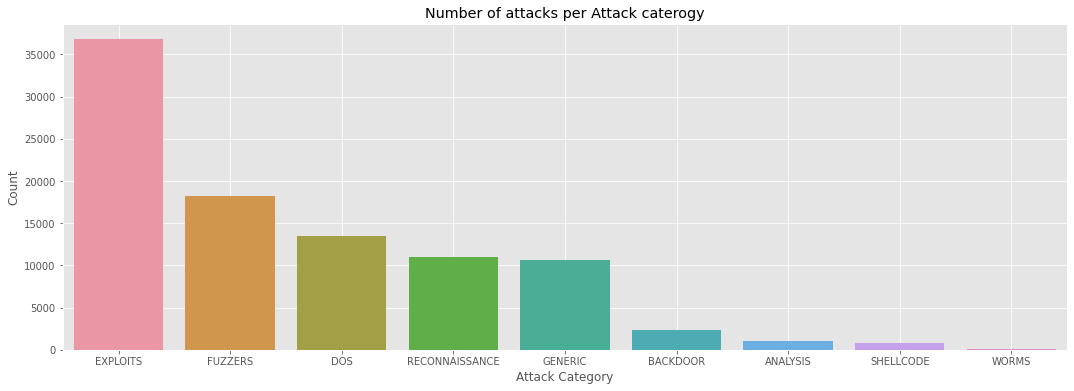

In [190]:
plt.figure(figsize=(18,6))
sns.barplot(x=newdf['Attack category'].value_counts().index,y=newdf['Attack category'].value_counts())
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.title('Number of attacks per Attack caterogy')
plt.grid(True)

In [191]:
pd.DataFrame(newdf['Attack category'].value_counts())[:]

,Attack category
EXPLOITS,36793
FUZZERS,18252
DOS,13484
RECONNAISSANCE,10963
GENERIC,10654
BACKDOOR,2308
ANALYSIS,1058
SHELLCODE,836
WORMS,96


In [192]:
a=pd.DataFrame(newdf['Attack category'].value_counts())[:6]

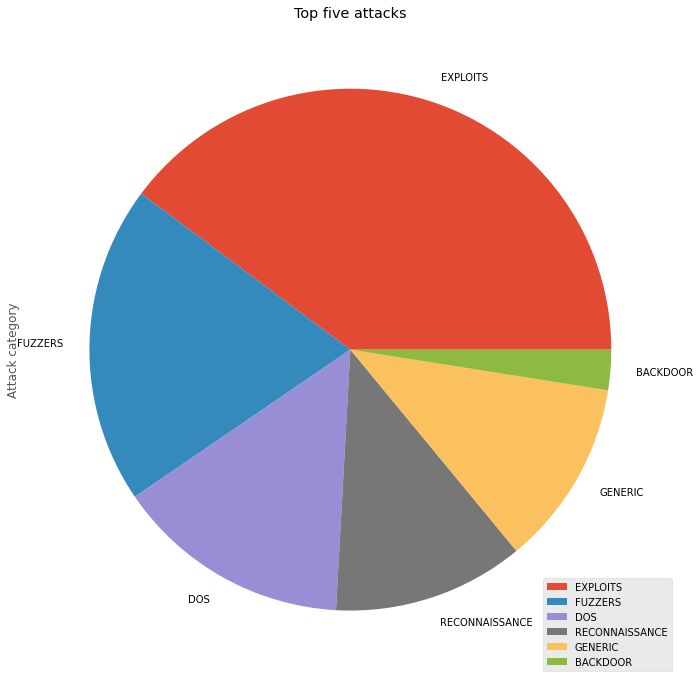

In [193]:
a.plot(kind='pie', subplots=True, figsize=(12, 12))
plt.title('Top five attacks')
plt.legend(loc='left')
plt.show()

# Time Analysis

We will begin by looking at the time values, but to do so, we will need to transform the data to a more readable format.




In [194]:
newdf['Start time']

0        1421930753
1        1421933441
2        1421930723
3        1424255680
4        1424258880
            ...    
94439    1424224898
94440    1424240116
94441    1424224609
94442    1424224898
94443    1424239612
Name: Start time, Length: 94444, dtype: object

Now that we know the format, and the beginning and end times in the data, we will transform the data, and add to it a duration column in seconds.

In [195]:
newdf['Start time'] = pd.to_datetime(newdf['Start time'], unit='s')
newdf['Last time'] = pd.to_datetime(newdf['Last time'], unit='s')
newdf['Duration'] = ((newdf['Last time'] - newdf['Start time']).dt.seconds).astype(int)

In [196]:
newdf[:5]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service,Duration
0,BACKDOOR,,UNAS,187.48.276.0,4300,149.171.126.12,3106,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 12:45:53,2015-01-22 12:45:53,CARDBOX-HTTP,0
1,BACKDOOR,,OSPF,175.45.171.2,4780,149.171.126.11,9338,Vtiger CRM Unauthenticated Password Reset (htt...,CVE 2014-2269 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 13:30:41,2015-01-22 13:31:39,NaN,58
2,BACKDOOR,,SCTP,175.45.171.3,8270,149.171.126.12,18703,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 12:45:23,2015-01-22 12:45:23,NaN,0
3,EXPLOITS,Apache,OSPF,175.45.171.3,9172,149.171.126.19,10987,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,2015-02-18 10:34:40,2015-02-18 10:34:41,NaN,1
4,EXPLOITS,Apache,UNAS,175.45.176.2,21663,149.171.126.17,8923,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,2015-02-18 11:28:00,2015-02-18 11:28:00,NaN,0


In [197]:
newdf['Start time'].astype(str).str.split(' ').str[0].unique()

array(['2015-01-22', '2015-02-18'], dtype=object)

As you can see from the above table, the start and Last time are now given in YYYY-MM-DD Time of Day. 

For ease and time, we will be looking at two days in partcular in the following cells: 

 - January 22, 2015
 - February 18, 2015

In [198]:
newdf.describe()

,Source Port,Destination Port,Duration
count,94444.000000,94444.000000,94444.000000
mean,21677.078491,7672.486585,2.366386
std,18453.290358,10111.864569,9.375939
min,0.000000,0.000000,0.000000
25%,7286.750000,110.000000,0.000000
50%,16390.000000,2965.500000,0.000000
75%,31913.500000,13860.000000,1.000000
max,65535.000000,65535.000000,60.000000


<h2>Interesting Findings</h2>

- Min & Max are identical
- Mean and 75% do not match

## Hypothesis Testing


$$ H_0: \mu_1=\mu_2$$
$$ H_a: \mu_1\neq\mu_2$$

We can obtain one of two results from the test:

1. If the **$p$-value** is less than our significance level ($p<\alpha$) we reject the null hypothesis $H_0$ and affirm that the observed difference is **statistically significant**.
2. If the **$p$-value** is greater than our significance level ($p>\alpha$) we will have to retain $H_0$ and conclude that the observed difference **is not statistically significant**.

The hypothesis test is conducted using a statistical **$T-test$** which specifies the two Series `df_interest['Source Port']` and `df_interest['Destination Port']`. 

<i>By specifying these two Series, we are automatically referring to a comparative test of the means of both Series:</i>

In [199]:
statistic, pvalue = stats.ttest_ind( newdf['Source Port'], newdf['Destination Port'], equal_var=False)
print('p-value in T-test: ' + str(pvalue))

p-value in T-test: 0.0


Because the $p$-value is very close to zero, Python approximates this measurement to 0.0. 

Therefore, we can reject the null hypothesis $H_0$ regarding the equality of the means of the source and destination ports. 
___
Meaning that the difference between the two <i>means</i> are significantly different.


### Correlation Coefficiant

We will be using two methods for correlation calculation:

- **<i>Pearson's correlation</i>**: evaluates the linear relationships between two variables. If the value is close to 0, there is a weak or nonexistent linear relationship between the variables.

- **<i>Spearman's correlation</i>**: evaluates the monotonic relationships between two variables. If the value is close to 0, there is a weak or nonexistent monotonic relationship between the variables.

___

<i>Definitions<i>

**Monotonic Relationship**: The variables tend to move in the same relative direction, but not necessarily at a constant rate. 

**Linear Relationship**: The variables move in the same direction at a constant rate.

[Source](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/linear-nonlinear-and-monotonic-relationships/)

In [200]:
newdf.corr(method='pearson')

,Source Port,Destination Port,Duration
Source Port,1.00000,-0.258110,-0.063530
Destination Port,-0.25811,1.000000,0.032883
Duration,-0.06353,0.032883,1.000000


Pearson shows us that the correlation between Source Port and Desitination Port are close to 0, showing signs that there is a weak or nonexistent linear relationship.
 
____

Now to check **Monotonic**

In [201]:
newdf.corr(method='spearman')

,Source Port,Destination Port,Duration
Source Port,1.000000,-0.308208,0.219465
Destination Port,-0.308208,1.000000,-0.273618
Duration,0.219465,-0.273618,1.000000


Using Spearman, we can see a value of 0.89, showing a strong likelihood that there is some form monotonic relationship.

The following are different ways to visually represent this data.

In [202]:
# df_dummies converts category values into a dummy or indicator value 

df_dummies = pd.get_dummies(newdf, columns=['Attack category'])

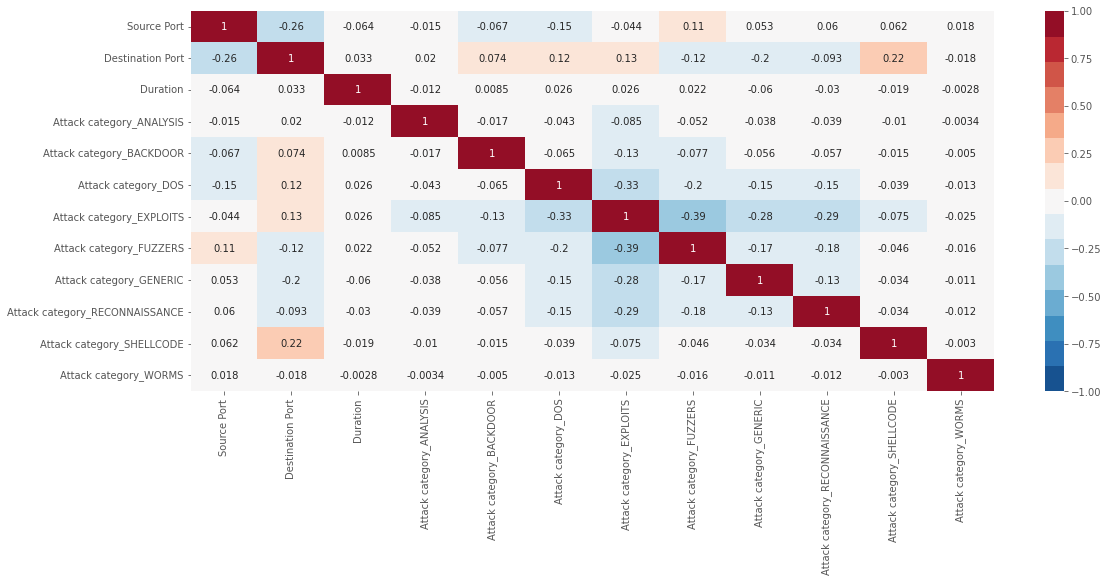

In [203]:
plt.figure(figsize=(18,7))
sns.heatmap(df_dummies.corr(method='pearson'), 
            annot=True, vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 15))
plt.show()

<h2>Pearson's Correlation<h2>

As seen with the overall calculation there is not much to see here, except 1 item.

- SHELLCODE & Destination Port

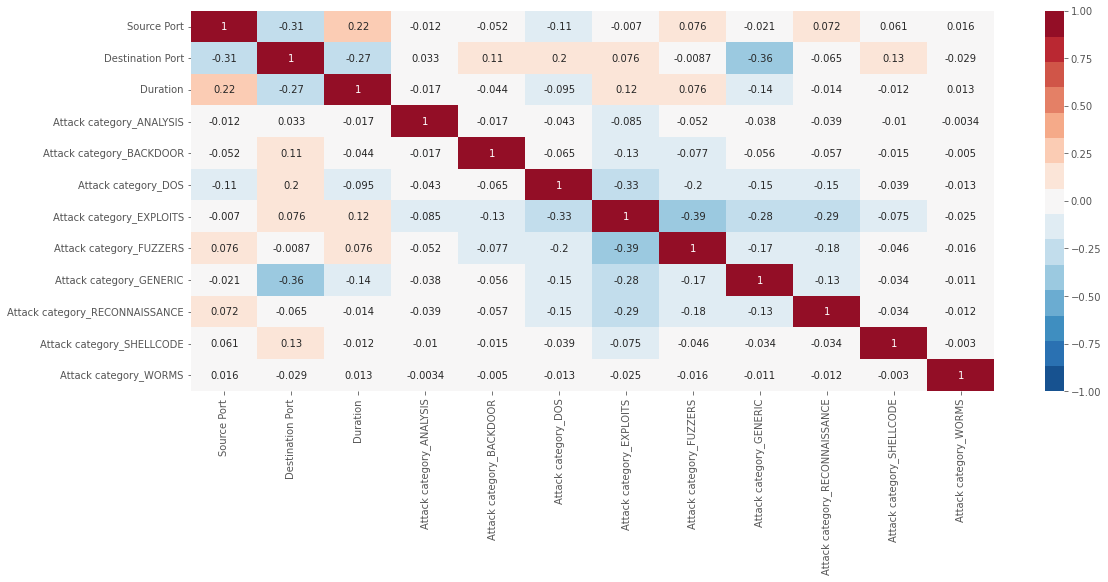

In [204]:
plt.figure(figsize=(18,7))
sns.heatmap(df_dummies.corr(method='spearman'), 
            annot=True, vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 15))
plt.show()


<h2>Spearman's Correlation</h2>

As we saw in the previous calculation, there is a high correlation between Destination and Source Port.

However, there seems to be something interesting with Duration as well, as you can see around the top left corner with .36 and .35.

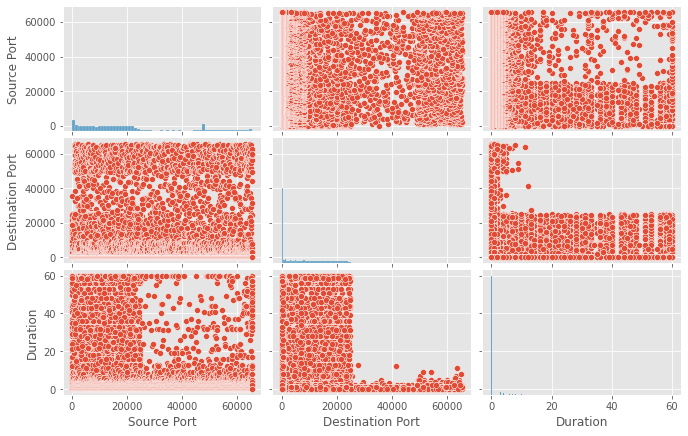

In [205]:
g = sns.pairplot(newdf)
g.fig.set_size_inches(10,6)
plt.show()

The above pairplot shows us that:

- Source Port x Destination Port: Nothing in particular
- Source Port x Duration: Under 20s, high and low ports
- Destination x Duration: Low ports and upper ports short time/lower ports varied with low time concentration

# Source & Destination Port Analysis

To get a better understanding of what is happening with <i>Source Port</i> and <i>Destination Port</i>, we will look to see where the attacks are happening. 


___

We will begin by looking at the IP Addresses being attacked, and see how often they show up in the data.

In [206]:
newdf['Destination IP'].value_counts()

149.171.126.17    23322
149.171.126.10    13018
149.171.126.19    11585
149.171.126.13    11069
149.171.126.18     7124
149.171.126.14     6639
149.171.126.12     6623
149.171.126.15     5672
149.171.126.11     5244
149.171.126.16     4148
Name: Destination IP, dtype: int64

The top IP Address has **43,199** attacks on it!

___

We will investigate this IP Address further, and start with time.

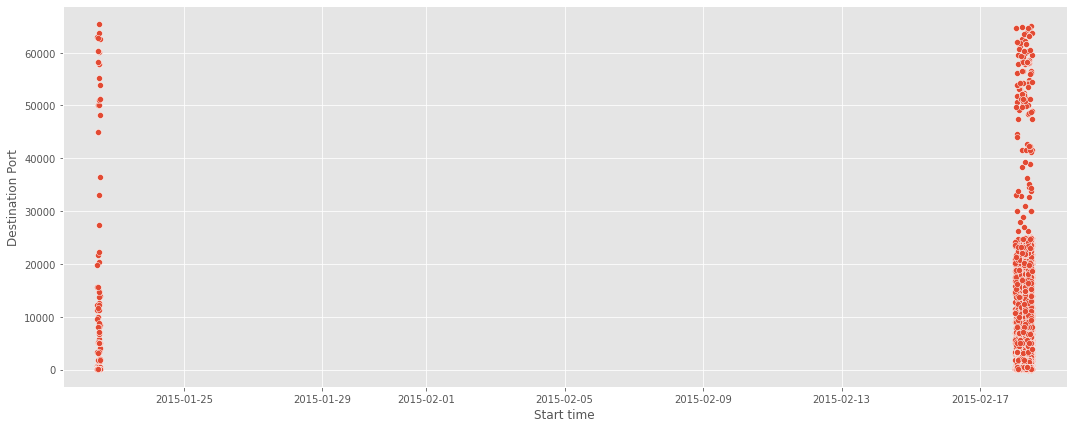

In [207]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=newdf['Start time'].min()-timedelta(days=1),right=newdf['Start time'].max()+timedelta(days=1))
plt.grid(True)
plt.show()

We are seeing some trending here, but we still need to investigate further.

___

We will start with the left side of the scatterplot from above.

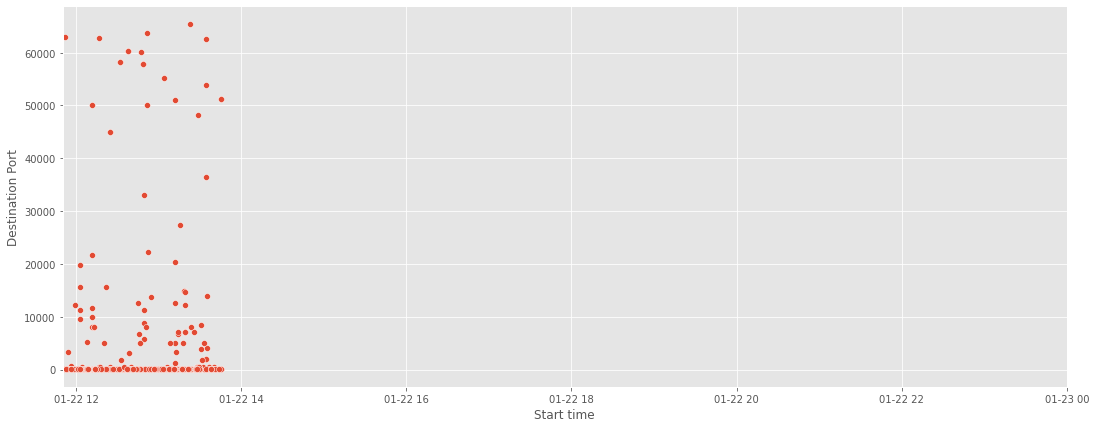

In [208]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=newdf['Start time'].min(),right=datetime.strptime('15-01-23', '%y-%m-%d'))
plt.grid(True)
plt.show()


We can now see that there is a strong concentration of attacks on the lower ports.

___

<h3>Right side Analysis</h3>

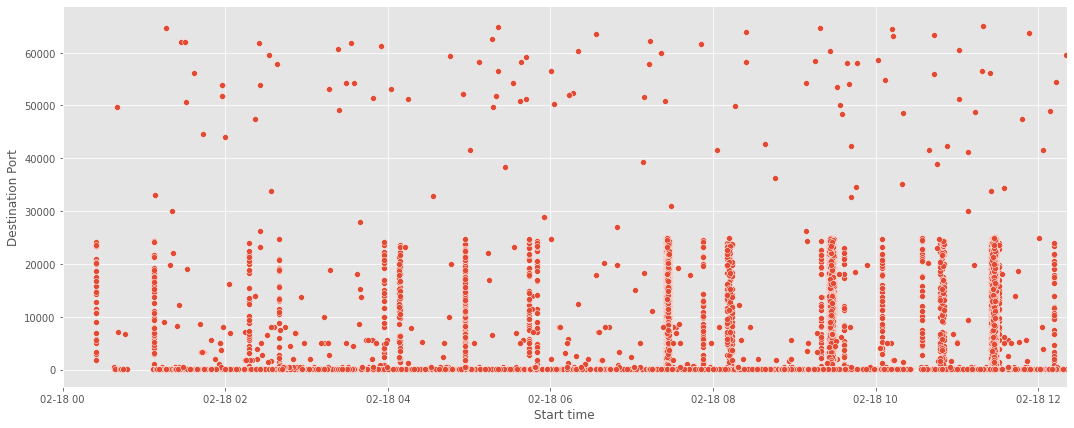

In [209]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=datetime.strptime('15-02-18', '%y-%m-%d'),right=newdf['Start time'].max())
plt.grid(True)
plt.show()

Very similar results to the left side

___

<h3>Ports <150</h3>

Since we have a lot of overlap on the x-axis, I would like to get a better idea of what is happening down where the concentration appears to by the highest.

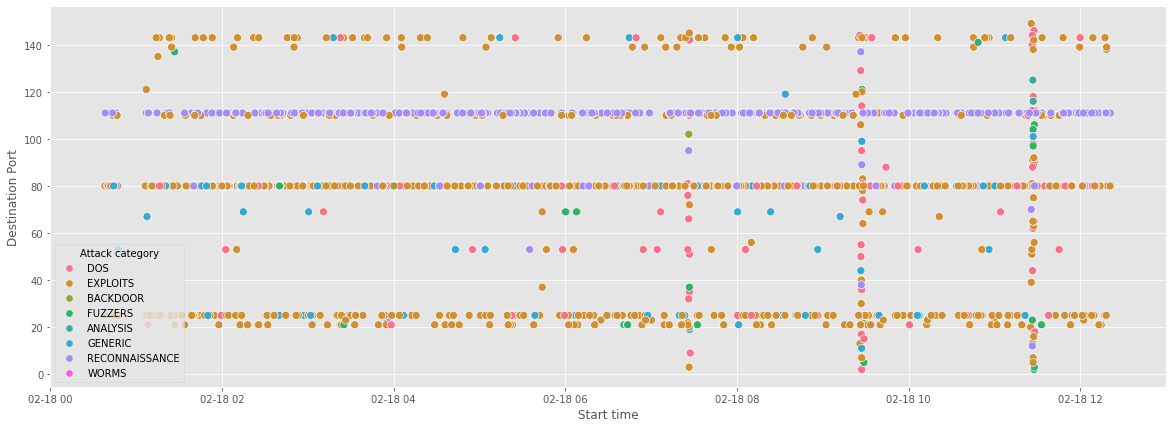

In [210]:
plt.figure(figsize=(20,7))
sns.scatterplot(x='Start time', y='Destination Port', hue='Attack category', 
                data=newdf[(newdf['Destination IP']=='149.171.126.17')&(newdf['Destination Port']<=150)], 
                s=65)
plt.xlim(left=datetime.strptime('15-02-18 00:00:00', '%y-%m-%d %H:%M:%S'),
         right=datetime.strptime('15-02-18 13:00:00', '%y-%m-%d %H:%M:%S'))
plt.grid(True)
plt.show()

We can now see a lot of 

- <i>**Backdoor**</i> attacks happening at the 21 and 25 port, those being the ftp and smtp (mail ports).
- <i>**Port 80**- HTTP</i> has alot of everything, esspecially <I>Exploits</I>

- <i>**Port 110**- POP</i> has alot of everything, esspecially <I>Reconnaissance</I>

# Duration & Destination Port Analysis

To begin we will use a scatterplot to see if there are any insights we can gleen from the data

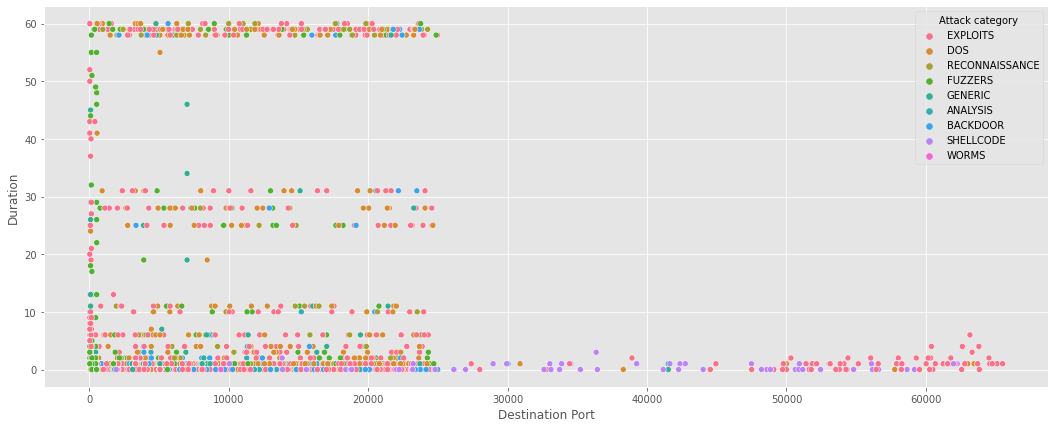

In [211]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Destination Port', y='Duration', hue='Attack category', data=newdf[newdf['Destination IP']=='149.171.126.17'])
plt.grid(True)
plt.show()

Most of the ports being attacked for long durations appear to be in the very low end of the values. 

Below is a violinplot, similar to a boxplot. 

- **Boxplot** shows summary statistics, e.g. mean, median, etc.
- **Violinplot** shows summary statistics & full data distribution

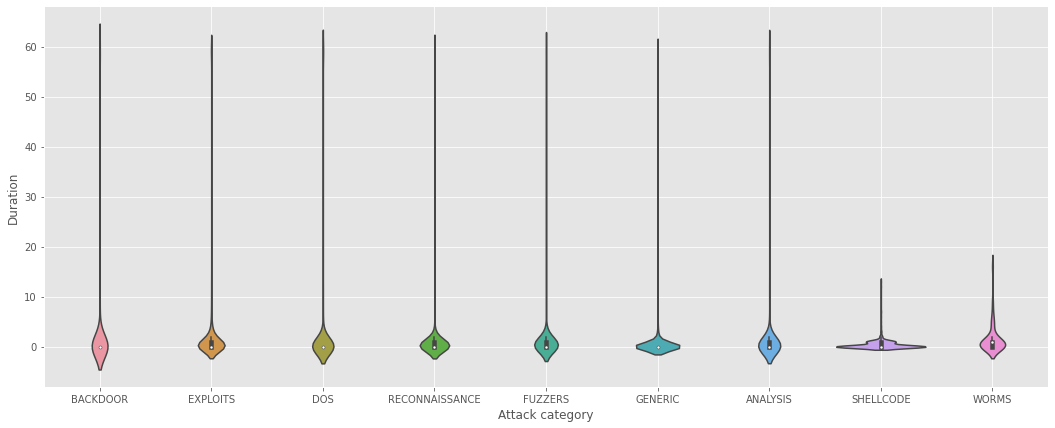

In [212]:
plt.figure(figsize=(18,7))
sns.violinplot(x='Attack category', y='Duration', data=newdf)
plt.grid(True)
plt.show()

Most of the Attack Categories appear to be normally distributed, except for SHELLCODE. 

- This violinplot is showing us that SHELLCODE his bimodal

The following code blocks will be used to set up a heatmap graph and pivot table.

In [213]:
def heatmap_graph(df, xlabel, ylabel, title):
    plt.figure(figsize=(18,8))
    ax = sns.heatmap(df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

In [214]:
newdf["Start time"][1].hour

13

In [215]:
df_pivot = newdf.copy()
df_pivot['hour'] = df_pivot.apply(lambda row: '0'*(2-len(str(row['Start time'].hour)))+str(row['Start time'].hour)+':00:00', axis=1)

In [216]:
# Creating a new df for the pivot table

df_pivot[:5]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service,Duration,hour
0,BACKDOOR,,UNAS,187.48.276.0,4300,149.171.126.12,3106,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 12:45:53,2015-01-22 12:45:53,CARDBOX-HTTP,0,12:00:00
1,BACKDOOR,,OSPF,175.45.171.2,4780,149.171.126.11,9338,Vtiger CRM Unauthenticated Password Reset (htt...,CVE 2014-2269 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 13:30:41,2015-01-22 13:31:39,NaN,58,13:00:00
2,BACKDOOR,,SCTP,175.45.171.3,8270,149.171.126.12,18703,HP Performance Manager Tomcat Bypass (https://...,CVE 2009-3548 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 12:45:23,2015-01-22 12:45:23,NaN,0,12:00:00
3,EXPLOITS,Apache,OSPF,175.45.171.3,9172,149.171.126.19,10987,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,2015-02-18 10:34:40,2015-02-18 10:34:41,NaN,1,10:00:00
4,EXPLOITS,Apache,UNAS,175.45.176.2,21663,149.171.126.17,8923,Apache HTTP Server mod_status Race Condition H...,CVE 2014-0226 (http://cve.mitre.org/cgi-bin/cv...,2015-02-18 11:28:00,2015-02-18 11:28:00,NaN,0,11:00:00


##Pivot Table

In [217]:
df_p1 = pd.pivot_table(df_pivot,values='Attack Name', index=['hour'], columns=['Attack category'], aggfunc='count')
df_p1

Attack category,ANALYSIS,BACKDOOR,DOS,EXPLOITS,FUZZERS,GENERIC,RECONNAISSANCE,SHELLCODE,WORMS
hour,,,,,,,,,
00:00:00,4,6,71,296,202,29,89,10,2
01:00:00,96,602,1460,3660,2440,970,1012,61,7
02:00:00,34,39,348,1570,1103,567,562,68,7
03:00:00,121,31,2082,5236,1466,762,1463,55,8
04:00:00,35,40,334,1437,1138,731,532,72,4
05:00:00,126,350,1679,5063,1390,999,914,66,8
06:00:00,52,62,360,1614,1137,536,563,54,5
07:00:00,100,309,1812,3282,1311,1118,1101,64,8
08:00:00,52,51,372,1628,1083,619,567,54,7


The pivot table shows us some rather random looking numbers but with some form of pattern as well. 

Let us try the heat map

##Heat Maps

The following heat map shows the number of attacks by attack type.
- Black will be <1000 where white is ~10,000 attacks

###Heat Map 1

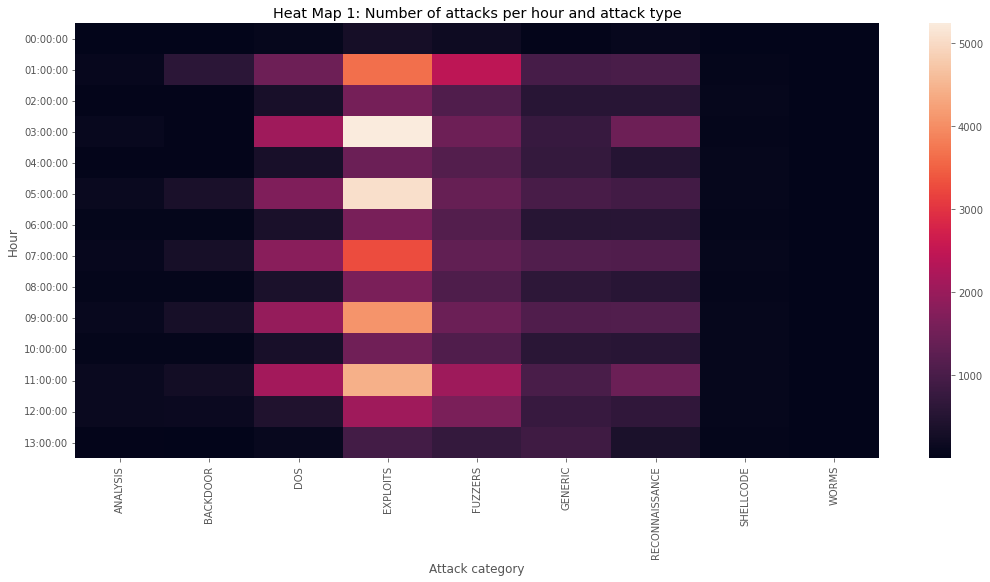

In [218]:
heatmap_graph(df = df_p1, xlabel = 'Attack category', ylabel = 'Hour', title = 'Heat Map 1: Number of attacks per hour and attack type')

**Insights from  Heat Map 1:**
- Analysis, Backdoor, Shellcode & Worms appear to be consistent throughout the day
- The remaining categoriess appear to have higher attacks on the odd hours of the day
- Exploits and DOS have shown to have the strongest patterning


###Heat Map 2

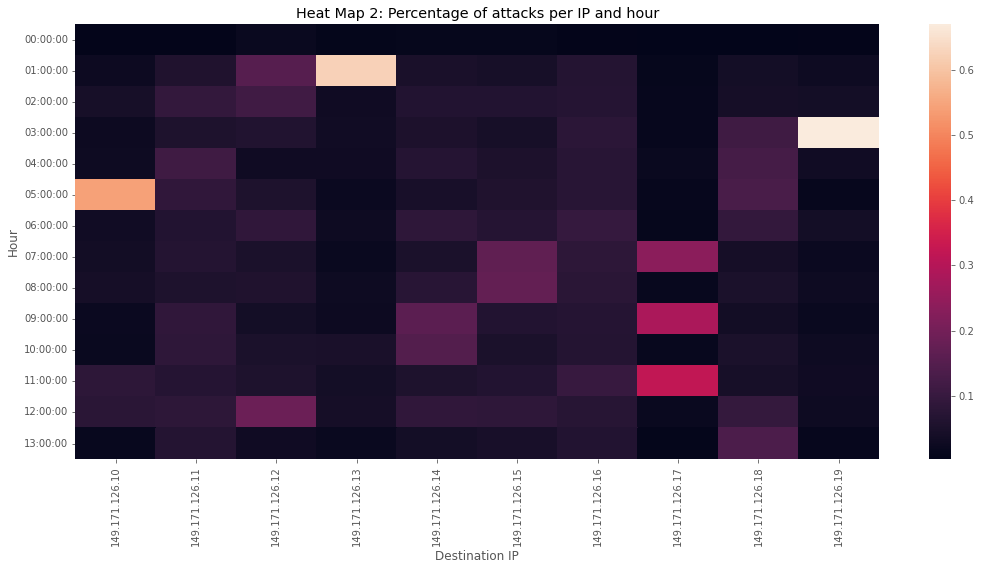

In [219]:
df_p2 = pd.pivot_table(df_pivot, values='Attack Name', index=['hour'], columns=['Destination IP'], aggfunc='count')
heatmap_graph(df = df_p2/df_p2.sum(), xlabel = 'Destination IP', ylabel = 'Hour', title = 'Heat Map 2: Percentage of attacks per IP and hour')

**Insights from  Heat Map 2:**
- IPv4 149.171.126.10 had a strong pattern showing of attacks at **5:00AM**
- IPv4 149.171.126.13 had a strong pattern showing of attacks at **1:00AM**
- IPv4 149.171.126.17 showed increased attacks at **7:00AM**, **9:00AM** & **11:00AM**
- IPv4 149.171.126.19 had a strong pattern showing of attacks at **3:00AM**

# Attack Category Analysis

##Heat Map 3

Since it is now clear that specific IPv4 addresses are being targetted, we will look more specifically at this data.

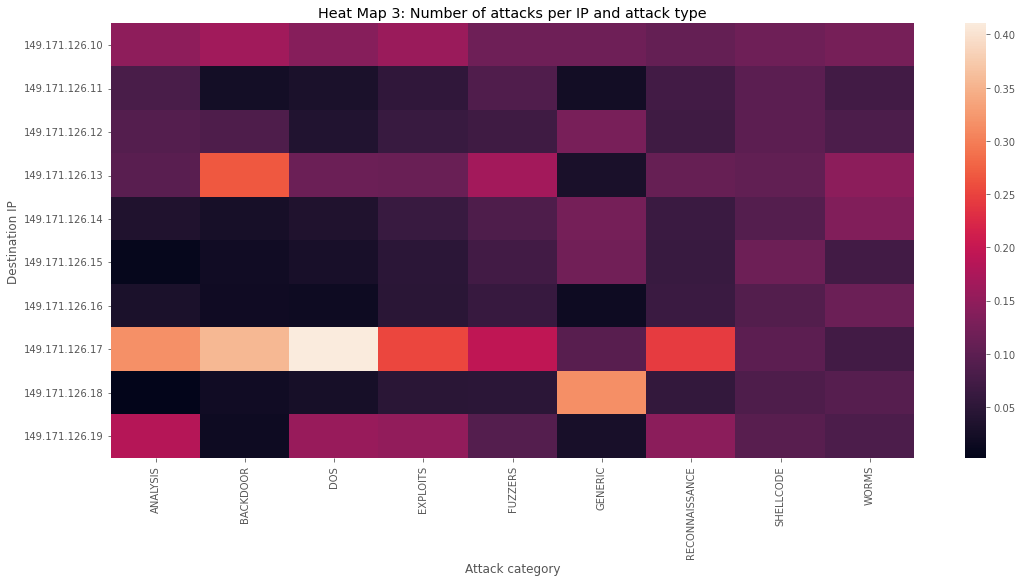

In [220]:
df_p3 = pd.pivot_table(df_pivot, values='Attack Name', index=['Destination IP'], columns=['Attack category'], aggfunc='count')
heatmap_graph(df = df_p3/df_p3.sum(), xlabel = 'Attack category', ylabel = 'Destination IP', title = 'Heat Map 3: Number of attacks per IP and attack type')

**Insights from  Heat Map 3:**
- **IPv4 149.171.126.17** had a strongest looking pattern across the 10 main IP addresses targetted 
- **DOS**, **Backdoor** & **Exploits** were the most concentrated attacks
- **Shellcode** has the most consistent attacks over the time period

## Pair-wise T-test

We will now look at the relationship between variables for Source Port and Destination Port, but by each Attack Category. 
- *Similar to before, except we are breaking it down by Attack Category*

In [221]:
for attack in list(newdf['Attack category'].unique()):
    df_attack = newdf[newdf['Attack category'] == attack].copy()
    statistic, pvalue = stats.ttest_ind(df_attack['Source Port'], df_attack['Destination Port'], equal_var=False)
    print('p-value in T-test for ' + attack + ' | ' + str(pvalue))

p-value in T-test for BACKDOOR | 2.158943970694699e-07
p-value in T-test for EXPLOITS | 0.0
p-value in T-test for DOS | 1.717129262522017e-261
p-value in T-test for RECONNAISSANCE | 0.0
p-value in T-test for FUZZERS | 0.0
p-value in T-test for GENERIC | 0.0
p-value in T-test for ANALYSIS | 7.44517659186169e-54
p-value in T-test for SHELLCODE | 0.015895325477160528
p-value in T-test for WORMS | 3.449635271236981e-26


The *𝑝-values* of all but one attack category are very close to 0.0.
- This means that the attacks have been directed to the specific ports *(except Shellcode)*

**Shellcode**: We cannot reject null hypothesiss, therefore there is a defined randomness, which means the source and destination ports have similar averages.

___

To verify this statement, we will make use of a contingency table which allows to relate the count of a certain pair of variables, similar to how we saw the .pivot_table()

In [222]:
df_crosstab = pd.crosstab(newdf['Attack category'], newdf['Destination Port'])
df_crosstab

Destination Port,0,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,30,31,32,35,36,37,38,39,40,41,42,43,44,45,...,65003,65011,65030,65043,65053,65054,65056,65060,65080,65104,65120,65127,65139,65176,65189,65198,65218,65219,65245,65262,65286,65287,65300,65311,65331,65361,65390,65398,65418,65420,65446,65455,65460,65470,65479,65486,65497,65502,65517,65535
Attack category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANALYSIS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BACKDOOR,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,4,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DOS,1,1,0,0,0,0,1,1,3,0,0,0,0,1,0,2,3,1,0,40,0,10,0,223,1,1,0,0,1,1,1,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EXPLOITS,0,0,1,1,0,3,0,0,0,0,0,2,0,1,2,1,2,0,3,1191,9,81,1,2357,1,0,1,0,1,0,1,4,2,1,1,1,6,0,1,2,...,1,1,1,2,1,1,0,1,2,2,3,2,2,0,1,2,3,2,2,0,3,1,2,1,1,1,1,2,2,2,1,1,2,2,2,1,3,1,1,0
FUZZERS,0,1,2,1,1,0,0,0,0,0,0,1,0,1,0,1,2,0,0,458,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GENERIC,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,16,5,0,0,231,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
RECONNAISSANCE,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SHELLCODE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WORMS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


From the contingency table using Attack type and Target port, we can see that the individual counts are not uniform. 
- This helps to affirm our inference that there is potentially some interaction between these two variables
___
We will need to test to see if these variations are actual differences, or outcomes of randomness in the data.

## Chi-square Test

While there are many ways to test the relationship between our variables, we will focus on the **Chi-square test**, as it is one of the more widely used tests, and easy to perform.

The null hypothesis for the Chi-square test is as follows:

$$
H_0:\text {The attack category is independent of the destination port}
$$

In [223]:
chi2, p_value, dof, expected = chi2_contingency(df_crosstab)
print("p-value of Chi-square test for Attack category vs. Destination Port =", p_value)

p-value of Chi-square test for Attack category vs. Destination Port = 0.0


As previously seen in the Hypothesis testing, our value for the Chi-square test is extremely small, and will be shown to us in python as 0.0
- Therefore, the destination port appearss to be somewhat dependant on the Attack category used.

To better visualize this relationship, we will use a scatterplot function to show us the Source Port along the x axis, the Destination Port on the y axis, and use the different attack categories for the colour (or hue). 

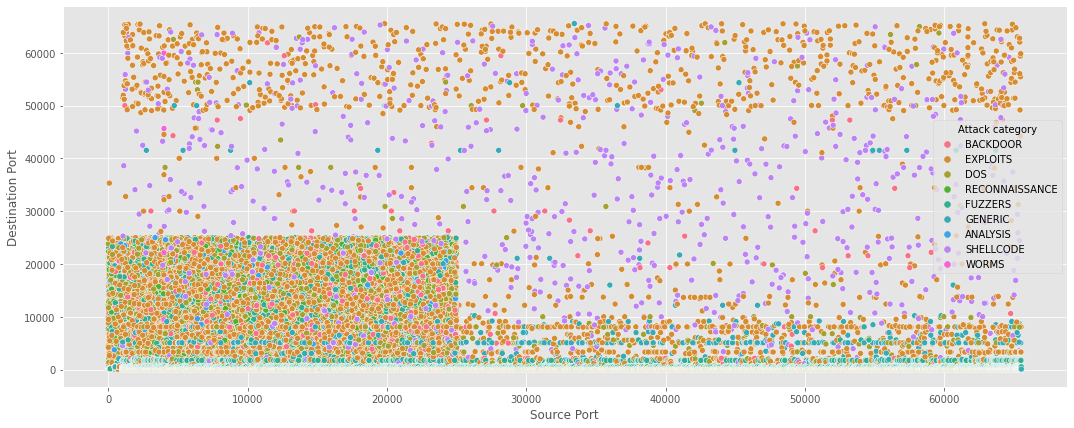

In [224]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Source Port',y='Destination Port', hue='Attack category',data=newdf)
plt.show()

Emerging Patterns
- Strong concentration of attacks on Destination Ports <10,000 and >50,000
- Strongest concentration at the lowest ports <150
- Shellcode appears to be equally distributed

## Strip Plot

To see this relationship more in depth, we can visualize the the distribution of the Attack Categories and Destination Ports with a strip diagram using the `.stripplot()` function:

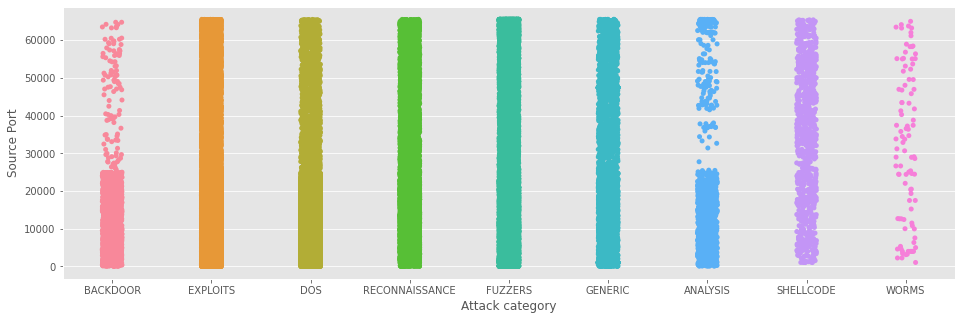

In [225]:
# Source ports
plt.figure(figsize=(16,5))
sns.stripplot(x='Attack category',y='Source Port',data=newdf)
plt.show()


As we saw with the data previously, there is a pretty even spread of the use of Source Port for all attack types.

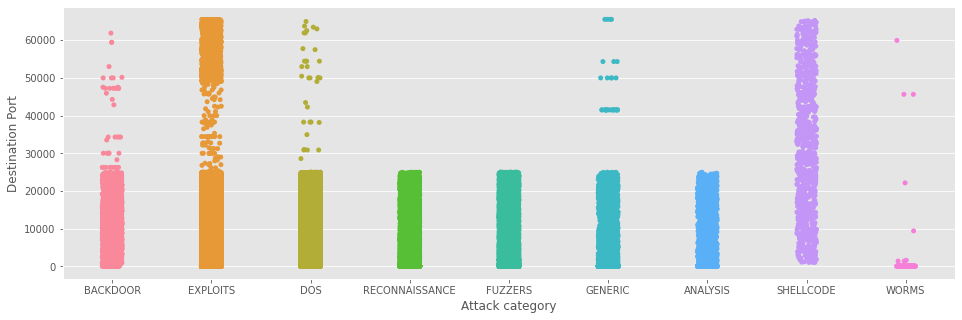

In [226]:

# Destination ports
plt.figure(figsize=(16,5))
sns.stripplot(x='Attack category',y='Destination Port',data=newdf)
plt.show()

Similar to Soure Ports, Destination Ports are showing us the same results ass the data. 
- Recon, DOS, Gen, Fuz, Worms, Ana all have a strong trend to target low number ports
- Exploits are relatively spread out, but with concentrations at the upper and lower bounds
- Shellcode is relatively uniformly distributed

## IPv4 Analysis

We will now look at the Attack Categories by

In [227]:
# Find unique Attacker IPv4

list(newdf['Source IP'].unique())

['187.48.276.0',
 '175.45.171.2',
 '175.45.171.3',
 '175.45.176.2',
 '187.48.276.1',
 '175.45.176.0',
 '175.45.195.1',
 '175.45.176.1',
 '175.45.186.6',
 '175.45.176.3',
 '175.45.186.5']

### Attacker IPv4

Below will split out the four unique IP Addresses we have for attackers, and compare the distribution of Attack Categories to the Destination Ports.

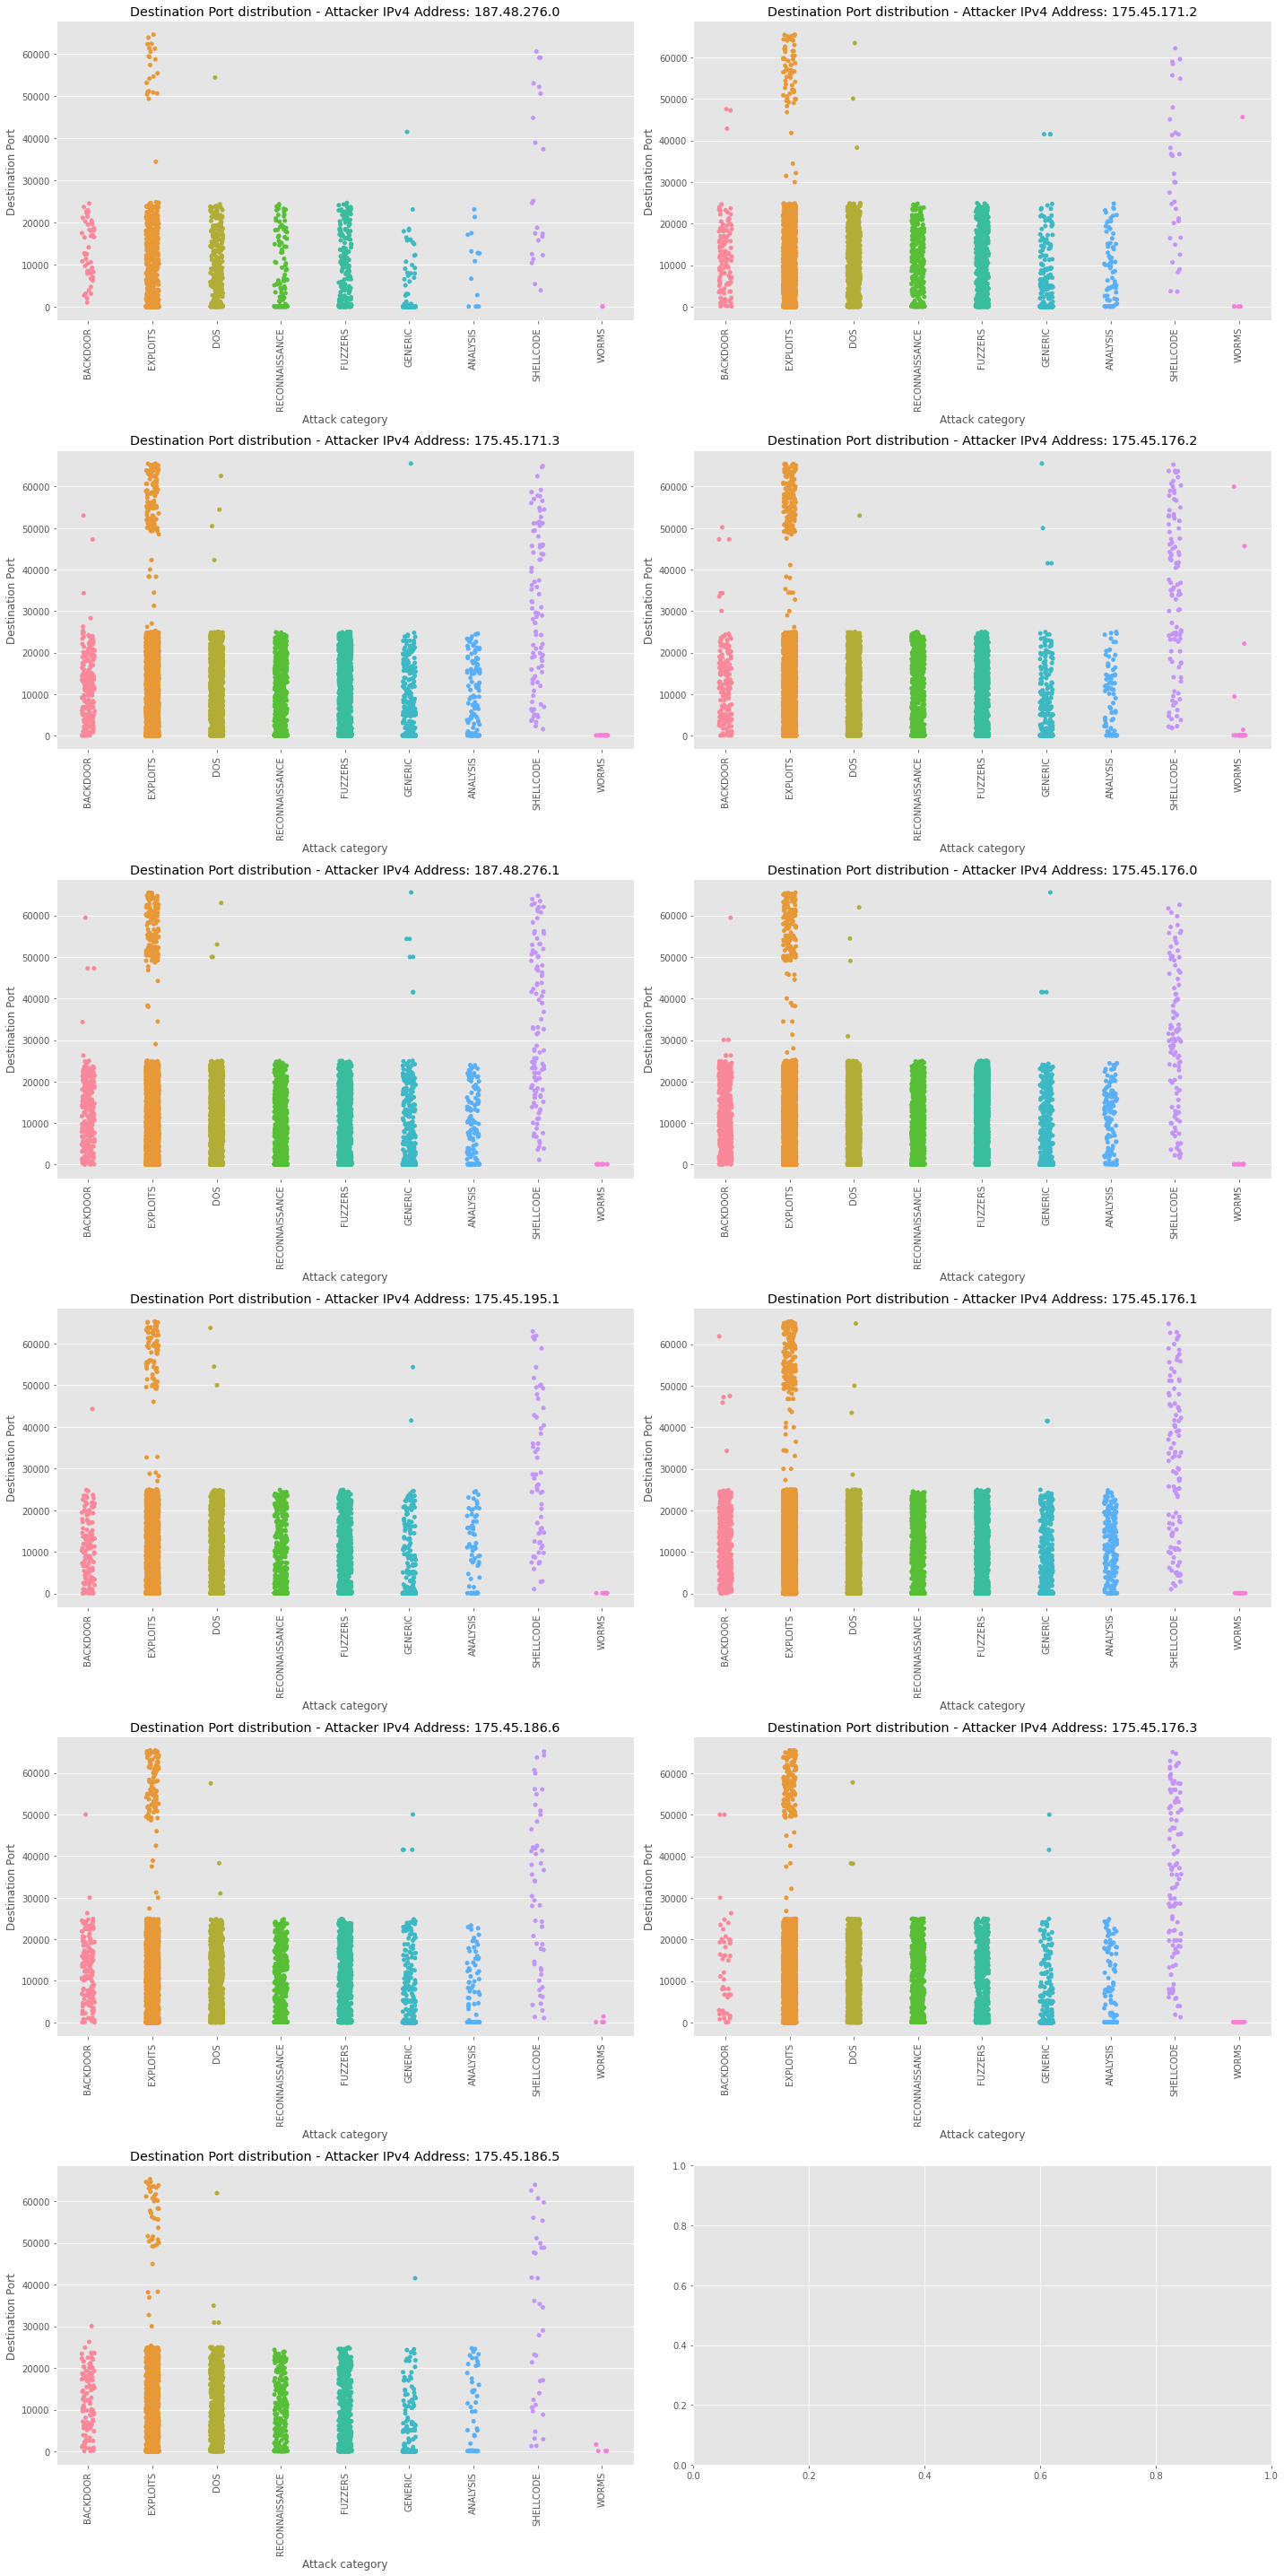

In [261]:
ips = list(newdf['Source IP'].unique())
f, axes = plt.subplots(6,2)
f.set_figheight(40)
f.set_figwidth(20)

labels = list(newdf['Attack category'].unique())
for i, ip in enumerate(ips):
    sns.stripplot(x='Attack category',y='Destination Port',data=newdf[newdf['Source IP'] == ip], order=labels, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_xlabel('Attack category')
    axes[int(i/2)][i%2].set_ylabel('Destination Port')
    axes[int(i/2)][i%2].set_title('Destination Port distribution - Attacker IPv4 Address: ' + ip)
    axes[int(i/2)][i%2].set_xticklabels(labels,rotation=90)
plt.tight_layout()
plt.show()

While there are obviously going to be some variance between the four graphs, we can clearly see similarity among the four different IPv4 values explored.

### Victim IPv4

We will complete the same exercise as above, but for the victim IP's.

In [262]:
list(newdf['Destination IP'].unique())


['149.171.126.12',
 '149.171.126.11',
 '149.171.126.19',
 '149.171.126.17',
 '149.171.126.10',
 '149.171.126.13',
 '149.171.126.15',
 '149.171.126.14',
 '149.171.126.18',
 '149.171.126.16']

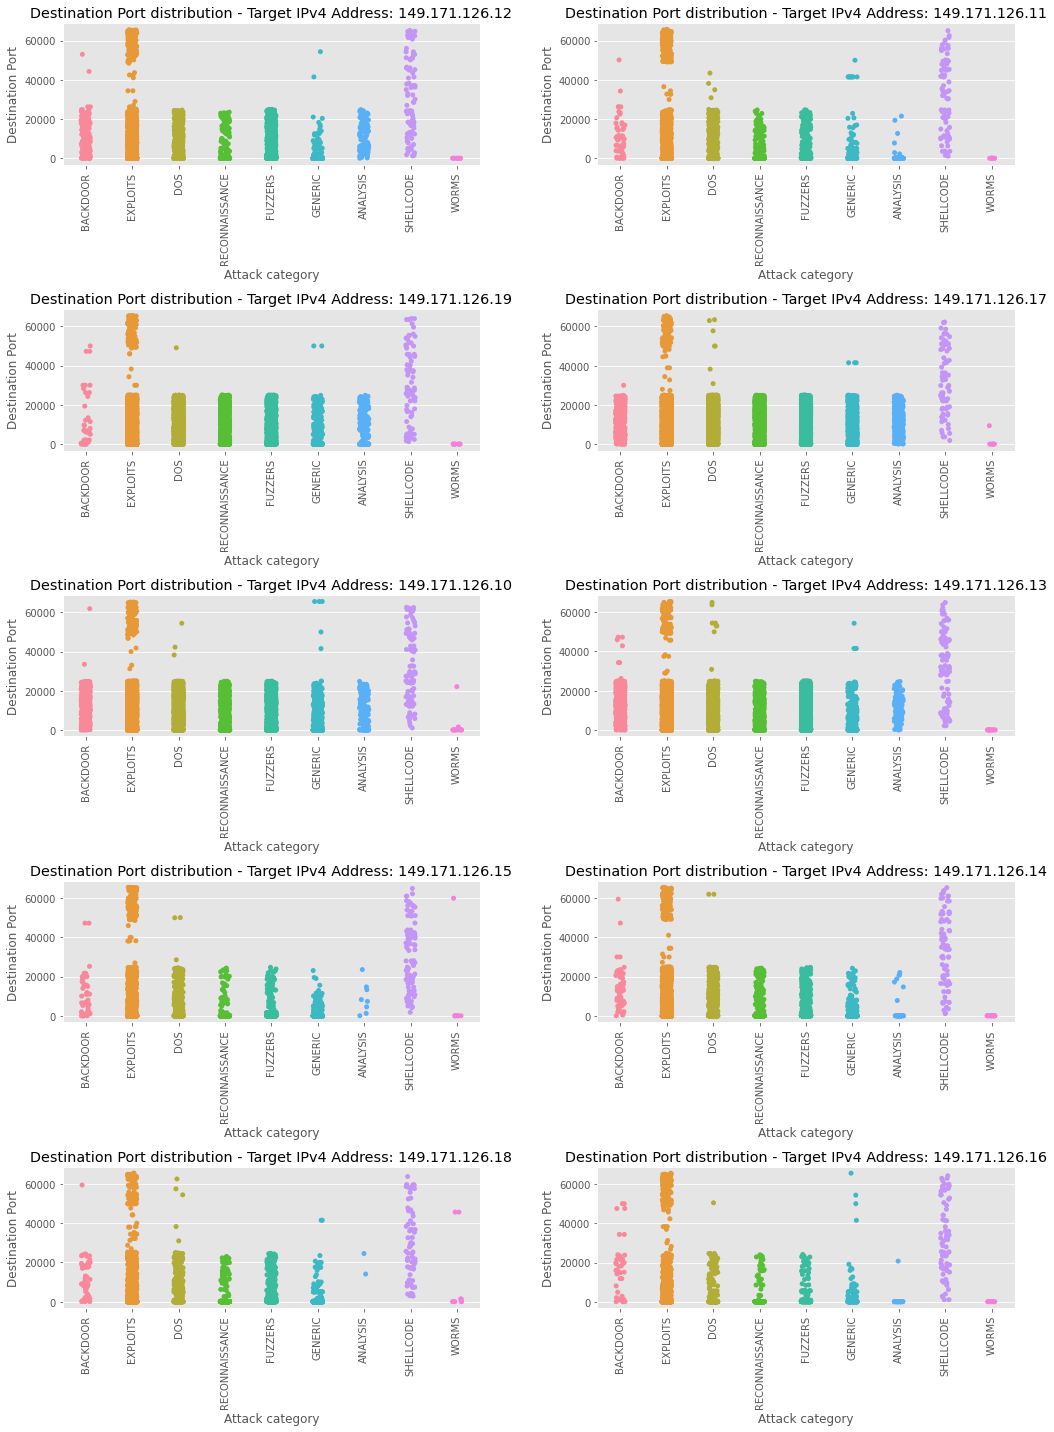

In [263]:
ips = list(newdf['Destination IP'].unique())
f, axes = plt.subplots(5, 2)
f.set_figheight(20)
f.set_figwidth(15)

labels = list(newdf['Attack category'].unique())

for i, ip in enumerate(ips):
    sns.stripplot(x='Attack category',y='Destination Port',data=newdf[newdf['Destination IP'] == ip], order=labels, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_xlabel('Attack category')
    axes[int(i/2)][i%2].set_ylabel('Destination Port')
    axes[int(i/2)][i%2].set_title('Destination Port distribution - Target IPv4 Address: ' + ip)
    axes[int(i/2)][i%2].set_xticklabels(labels,rotation=90)
plt.tight_layout()
plt.show()

We can see that there is some basic variance between the IPv4 addresses and how they were attacked, namely DOS, but they are all relatively aligned with what our previous analysis has shown.

# Conclusion